## Evaluación con nuevos datos

En este notebook evaluaremos el comportamiento de nuestro modelo que pasará a producción con nuevos datos. Estos datos contienen información sobre los combates que se han realizado desde que realizamos la última extracción. Estudiaremos como se desenvuelve el modelo con estos datos que nunca ha "visto" y si se ha producido algún cambio de tendencia que pueda cauar problemas o un deterioro de nuestro modelo en el futuro.

## Índice

* [Carga de datos](#carga-de-datos)
* [Separación en train y test](#separacion-en-train-y-test)
* [Entrenamiento y evaluación del modelo](#entrenamiento-y-evaluacion-del-modelo)
* [Estudio cambios y distribuciones en los nuevos datos](#estudio-cambios-y-distribuciones-en-los-nuevos-datos)
* [Entreno final y preparación para pasarlo a producción](#entreno-final-del-modelo-para-pasarlo-a-produccion)

In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Carga de datos

Cargo el dataframe completo, con los nuevos datos incluidos.

In [2]:
ruta_df =  os.path.join("..","..","..", "data", "processed","peleas.parquet")
df = pd.read_parquet(ruta_df)
df

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Laverne Clark,Frank Caracci,1999-01-08,LIGHTWEIGHT,False,KO/TKO,412,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Pedro Rizzo,Mark Coleman,1999-01-08,HEAVYWEIGHT,False,Decision - Split,180,2,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Mikey Burnett,Townsend Saunders,1999-01-08,LIGHTWEIGHT,False,Decision - Unanimous,180,2,1,0,...,0,0,1,0,0,0,0,0,0,1
3,Bas Rutten,Tsuyoshi Kohsaka,1999-01-08,HEAVYWEIGHT,False,KO/TKO,135,2,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Evan Tanner,Darrel Gholar,1999-01-08,MIDDLEWEIGHT,False,Submission,477,1,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,Josh Emmett,Lerone Murphy,2025-04-12,FEATHERWEIGHT,True,Decision - Unanimous,300,5,0,0,...,0,0,6,7,1,0,1,0,3,0
7934,Martin Buday,Uran Satybaldiev,2025-04-12,HEAVYWEIGHT,False,Decision - Unanimous,300,3,0,0,...,1,0,5,0,1,0,0,0,0,1
7935,Torrez Finney,Robert Valentin,2025-04-12,MIDDLEWEIGHT,False,Decision - Split,300,3,0,0,...,0,0,1,0,0,1,0,0,0,1
7936,Brad Tavares,Gerald Meerschaert,2025-04-12,MIDDLEWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,11,14,0,5,4,0,2,5,5


### Separacion en train y test

Separo los datos antiguos de los nuevos datos

In [ ]:
df["DATE"] = pd.to_datetime(df["DATE"])

# Filtra los combates después del 16 de febrero de 2025
df_antiguos = df[df["DATE"] <= "2025-02-16"]
df_nuevos = df[df["DATE"] > "2025-02-16"]
df_nuevos

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
7844,Rodolfo Vieira,Andre Petroski,2025-02-22,MIDDLEWEIGHT,True,Decision - Unanimous,300,3,0,0,...,5,2,0,5,0,2,1,0,2,0
7845,Don'Tale Mayes,Valter Walker,2025-02-22,HEAVYWEIGHT,True,Submission,77,1,0,0,...,0,2,2,0,0,0,3,0,3,1
7846,Julia Avila,Jacqueline Cavalcanti,2025-02-22,BANTAMWEIGHT,True,Decision - Unanimous,300,3,0,0,...,1,0,1,4,0,0,1,0,2,0
7847,Jared Cannonier,Gregory Rodrigues,2025-02-22,MIDDLEWEIGHT,False,KO/TKO,21,4,2,2,...,0,0,4,2,3,2,0,0,5,1
7848,Edmen Shahbazyan,Dylan Budka,2025-02-22,MIDDLEWEIGHT,False,KO/TKO,95,1,1,0,...,1,0,1,0,3,2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,Josh Emmett,Lerone Murphy,2025-04-12,FEATHERWEIGHT,True,Decision - Unanimous,300,5,0,0,...,0,0,6,7,1,0,1,0,3,0
7934,Martin Buday,Uran Satybaldiev,2025-04-12,HEAVYWEIGHT,False,Decision - Unanimous,300,3,0,0,...,1,0,5,0,1,0,0,0,0,1
7935,Torrez Finney,Robert Valentin,2025-04-12,MIDDLEWEIGHT,False,Decision - Split,300,3,0,0,...,0,0,1,0,0,1,0,0,0,1
7936,Brad Tavares,Gerald Meerschaert,2025-04-12,MIDDLEWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,11,14,0,5,4,0,2,5,5


Uso como train los datos que ya teniamos, los nuevos datos obtenidos serán el conjunto de test.

In [4]:
X_train = df_antiguos.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_train = df_antiguos["WINNER"]
X_test = df_nuevos.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_test = df_nuevos["WINNER"]

### Entrenamiento y evaluacion del modelo

Cargo el mejor modelo obtenido en la evaluación anterior.

In [5]:
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

y_pred = mejor_xgboost.predict(X_test)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f"F1-score: {f1_score(y_test,y_pred)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       1.00      0.90      0.95        51
        True       0.90      1.00      0.95        43

    accuracy                           0.95        94
   macro avg       0.95      0.95      0.95        94
weighted avg       0.95      0.95      0.95        94

Accuracy: 0.9468
F1-score: 0.945054945054945


El accuracy se mantiene similar al obtenido en la evaluación de la fase anterior. Esto nos indica que el desempeño del modelo no se ve empeorado con los nuevos datos.

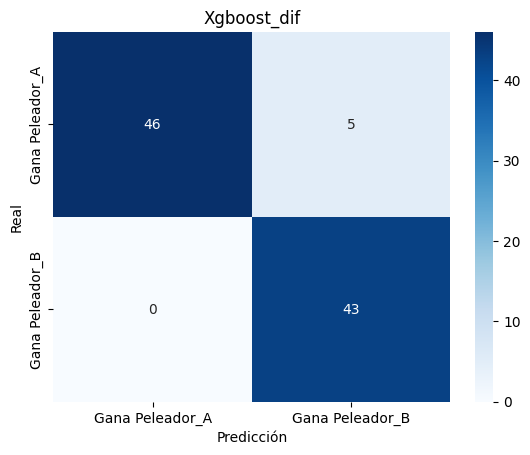

In [14]:
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost_dif')
plt.show()

In [6]:

# Crear un DataFrame para las importancias de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mejor_xgboost.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
45         KD_DIFF    0.092654
41  STR_GROUND_A_x    0.080517
46    SIG_STR_DIFF    0.076222
48    SUB_ATT_DIFF    0.049388
13   TOTAL_STR_A_x    0.047571
..             ...         ...
29     STR_LEG_A_x    0.001779
25    STR_BODY_A_x    0.001775
31     STR_LEG_B_x    0.001515
9            REV_A    0.001439
5        TD_PORC_A    0.001112

[75 rows x 2 columns]


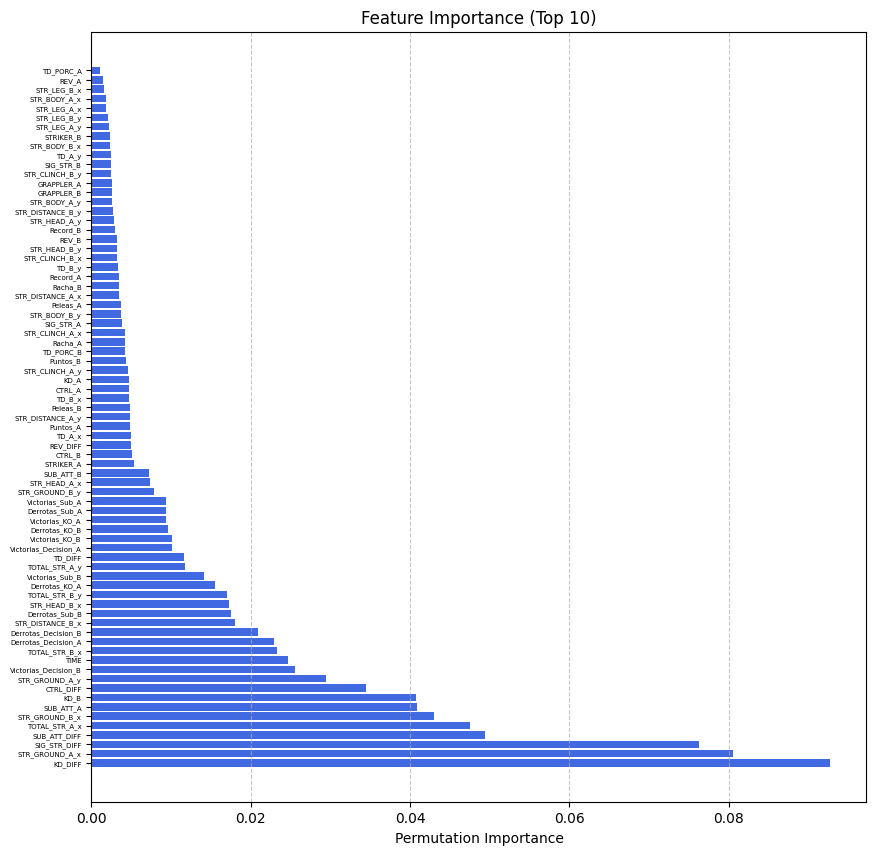

In [7]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Las importancias se mantienen similares a las que obtuvimos en la fase anterior.

### Estudio cambios y distribuciones en los nuevos datos

In [12]:
y_test.value_counts(normalize=True)

WINNER
False    0.542553
True     0.457447
Name: proportion, dtype: float64

Las proporciones de la variable respuesta no han variado y siguen una distribución similar a la estudiada en la anterior fase.

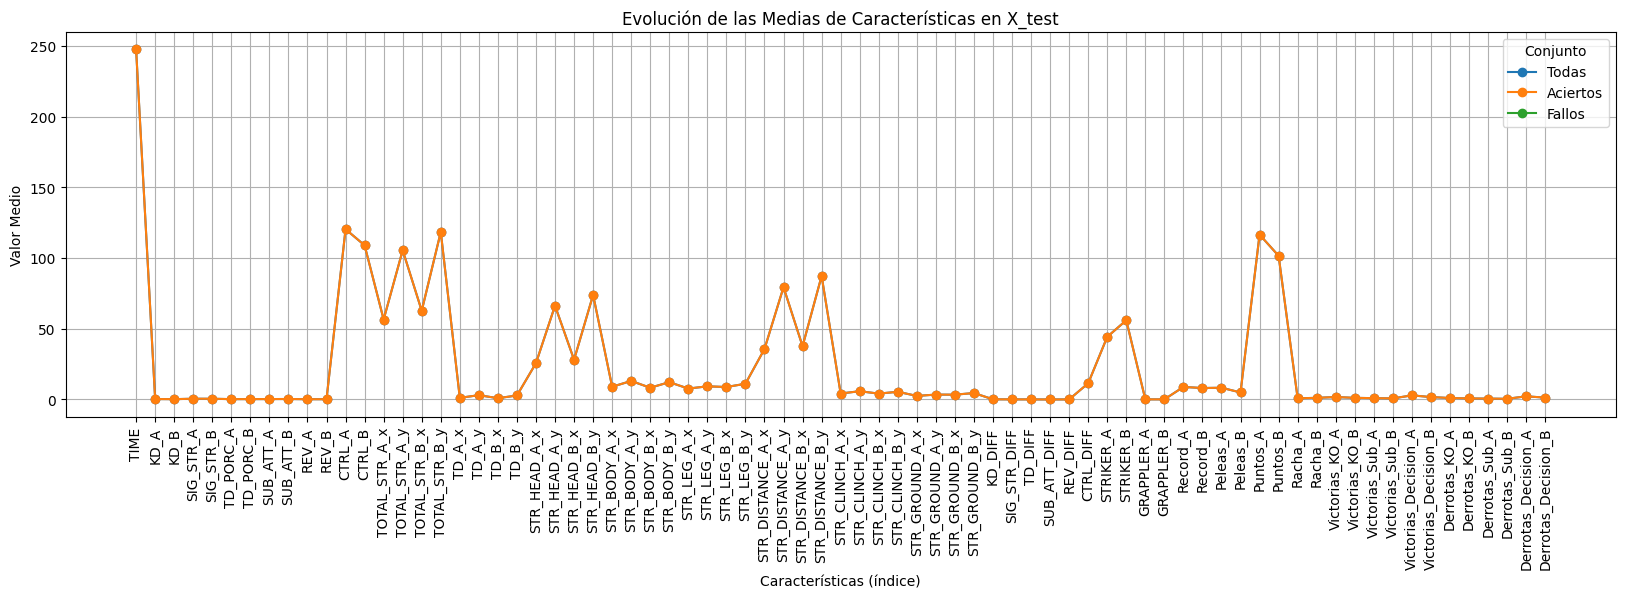

In [15]:
# Obtener las probabilidades de la clase 1 y las predicciones en X_test
y_prob = mejor_xgboost.predict_proba(X_test)[:, 1]
y_pred = mejor_xgboost.predict(X_test)

mediasNormales = y_prob
mediasAciertos = np.where(y_pred == y_test, y_prob, np.nan)
mediasFallos = np.where(y_pred != y_test, y_prob, np.nan)

# Crear un DataFrame con las tres series
data = {
    'Todas': mediasNormales,
    'Aciertos': mediasAciertos,
    'Fallos': mediasFallos
}
df = pd.DataFrame(data)

# Seleccionar 10 muestras representativas (por ejemplo, las primeras 10)
df_subset = df.head(10)
# [Se ha eliminado la tabla que mostraba estos datos]

# Crear DataFrame de resultados con las etiquetas reales y predichas
resultados = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred
})
resultados["Correcto"] = resultados["Real"] == resultados["Predicho"]

# Dividir en aciertos y fallos
aciertos = resultados[resultados["Correcto"] == True]
fallos = resultados[resultados["Correcto"] == False]

# Si X_test es numérico, se pueden calcular las medias de cada característica:
mediasNormales = X_test.mean()
mediasAciertos = X_test.loc[aciertos.index].mean()
mediasFallos = X_test.loc[fallos.index].mean()

# Crear un DataFrame resumen con las medias de las características
data_resumen = {
    'Todas': mediasNormales,
    'Aciertos': mediasAciertos,
    'Fallos': mediasFallos
}
df_resumen = pd.DataFrame(data_resumen)

# Graficar la evolución de las medias (por índice de columna)
plt.figure(figsize=(20, 5))
df_resumen.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Evolución de las Medias de Características en X_test')
plt.xlabel('Características (índice)')
plt.ylabel('Valor Medio')
plt.legend(title='Conjunto')
plt.grid(True)
plt.xticks(ticks=range(len(df_resumen.index)), labels=df_resumen.index, rotation=90)
plt.show()

En este caso vemos que las características siguen la misma tendencia que en la última evaluación esto nos indica que los datos siguen manteniendo las mismas tendencias que en los dato antiguos. Por lo tanto podemos concluir que en estos dos meses las tendencias de las variables respecto a el ganador de la pelea no han tenido gran variación.

### Entreno final del modelo para pasarlo a produccion

In [8]:
X_train = df.drop(columns=["WINNER","DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])
y_train = df["WINNER"]

In [9]:
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Entreno el modelo con todos los datos completos para pasarlo a producción de la forma más completa posible.

In [10]:
ruta_modelo = os.path.join("..","..","..", "data", "xgboost_P1.xgb")
mejor_xgboost.save_model(ruta_modelo)


c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
